# K-Means Clustering

The final goal of the code file is to build a system that recommends scientific papers (research papers) based on content similarity. Specifically:

* Use Universal Sentence Encoder (USE) to convert the titles, authors, and abstracts of the papers into numeric vectors (embeddings). (reused from /parquets)
* Apply the K-Means Clustering algorithm to group the papers into clusters with similar content.
* Use the Cosine Similarity measure to recommend other papers in the same cluster as the paper that the user is interested in.
* Evaluate the optimal number of clusters using Silhouette Score and visualize the results using PCA.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import required libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load in the preprocessed dataset splits
trnDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/train.parquet.gzip")
tstDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/test.parquet.gzip")
valDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/val.parquet.gzip")
cleanedDF:pd.DataFrame = pd.read_parquet("/content/drive/MyDrive/dataset/parquets/cleaned.parquet.gzip")

Tuning the number of clusters (K) using silhouette score...
K=5, Silhouette Score=0.0120
K=10, Silhouette Score=-0.0065
K=15, Silhouette Score=-0.0142
K=20, Silhouette Score=-0.0093
K=25, Silhouette Score=-0.0209
K=30, Silhouette Score=-0.0203
K=35, Silhouette Score=-0.0247
K=40, Silhouette Score=-0.0237
K=45, Silhouette Score=-0.0305
K=50, Silhouette Score=-0.0262

Best number of clusters (K): 5


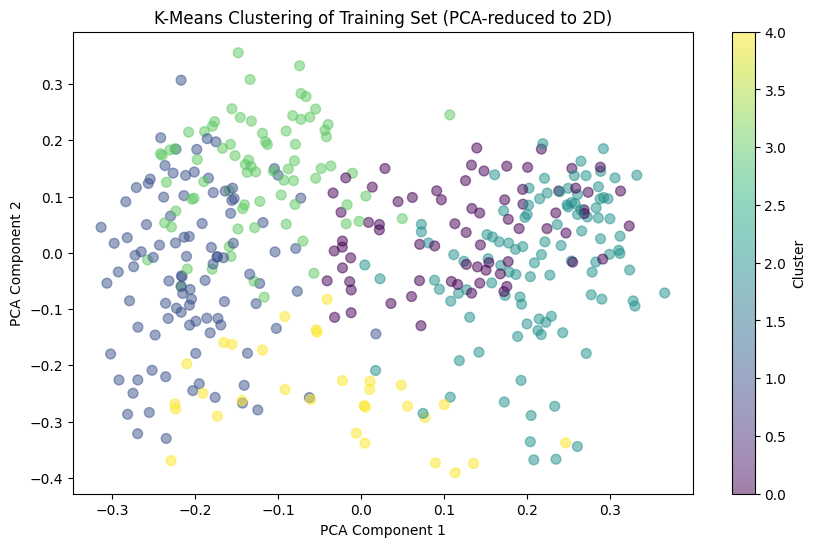

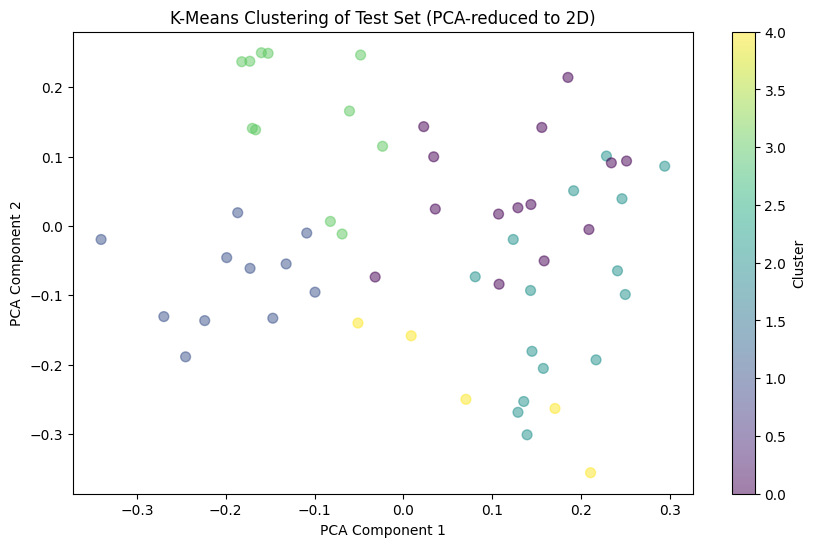


Testing recommender system for paper at test index 0 (Cluster 0):
Average cosine similarity to papers in the same cluster: 0.38919734954833984
Average cosine similarity to random papers: 0.35344186425209045

Test paper title: Replay Attack Detection Using Linear Prediction Analysis-Based Relative Phase Features

Recommended papers based on clustering:
1. Robust Network Intrusion Detection System Based on Machine-Learning With Early Classification
2. A Distributed Survivable Routing Algorithm for Mega-Constellations With Inclined Orbits
3. Identifying Incorrect Patches in Program Repair Based on Meaning of Source Code
4. Three-Dimensional Reconstruction of Fuzzy Medical Images Using Quantum Algorithm
5. A Fast Fusion Method for Visible and Infrared Images Using Fourier Transform and Difference Minimization


In [7]:
# Define the embedding columns (512 dimensions each for title, authors, abstract)
title_cols = [f"title_emb_{i}" for i in range(512)]
authors_cols = [f"authors_emb_{i}" for i in range(512)]
abstract_cols = [f"abstract_emb_{i}" for i in range(512)]
all_emb_cols = title_cols + authors_cols + abstract_cols  # Total 1536 features

# Extract feature matrices from the DataFrames
X_train = trnDF[all_emb_cols].values
X_val = valDF[all_emb_cols].values
X_test = tstDF[all_emb_cols].values

# Normalize the feature vectors to unit norm (for cosine similarity equivalence)
X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_test_norm = normalize(X_test)

# Tune the number of clusters (K) using silhouette score on the validation set
k_values = range(5, 51, 5)  # Test K from 5 to 50 with step 5
silhouette_scores = []

print("Tuning the number of clusters (K) using silhouette score...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_norm)  # Fit on training data
    val_labels = kmeans.predict(X_val_norm)  # Predict clusters for validation data
    # Use a sample size for efficiency (e.g., 1000 points)
    score = silhouette_score(X_val_norm, val_labels, sample_size=1000, random_state=42)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Select the best K based on the highest silhouette score
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters (K): {best_k}")

# Train the final K-Means model with the best K on the training data
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_final.fit(X_train_norm)

# Assign clusters to the test set
test_labels = kmeans_final.predict(X_test_norm)

# ---- Visualization ----
# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_norm)

# Plot the training set clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_final.labels_, cmap='viridis', s=50, alpha=0.5)
plt.title('K-Means Clustering of Training Set (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Plot the test set clusters
X_test_pca = pca.transform(X_test_norm)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap='viridis', s=50, alpha=0.5)
plt.title('K-Means Clustering of Test Set (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# ---- Testing the Recommender System ----
# Select a test paper (e.g., the first one in the test set)
test_paper_index = 0
test_paper_cluster = test_labels[test_paper_index]
print(f"\nTesting recommender system for paper at test index {test_paper_index} (Cluster {test_paper_cluster}):")

# Find other papers in the same cluster (excluding the test paper itself)
same_cluster_indices = np.where(test_labels == test_paper_cluster)[0]
same_cluster_indices = same_cluster_indices[same_cluster_indices != test_paper_index]

# Compute cosine similarity between the test paper and others in the same cluster
test_paper_vector = X_test_norm[test_paper_index].reshape(1, -1)
if len(same_cluster_indices) > 0:
    similarities = cosine_similarity(test_paper_vector, X_test_norm[same_cluster_indices])
    average_similarity = np.mean(similarities)
else:
    average_similarity = None
    print("Note: No other papers in the same cluster.")

# Compute cosine similarity to a random set of papers for comparison
random_indices = np.random.choice(len(X_test_norm), size=min(10, len(same_cluster_indices)), replace=False)
random_similarities = cosine_similarity(test_paper_vector, X_test_norm[random_indices])
average_random_similarity = np.mean(random_similarities)

# Display similarity results
print(f"Average cosine similarity to papers in the same cluster: {average_similarity if average_similarity else 'N/A'}")
print(f"Average cosine similarity to random papers: {average_random_similarity}")

# Retrieve and display the titles for manual inspection
test_paper_id = tstDF.iloc[test_paper_index]["id"]
test_paper_title = cleanedDF[cleanedDF["Id"] == test_paper_id]["title"].values[0]
print(f"\nTest paper title: {test_paper_title}")

if len(same_cluster_indices) > 0:
    recommended_ids = tstDF.iloc[same_cluster_indices]["id"].values
    recommended_titles = cleanedDF[cleanedDF["Id"].isin(recommended_ids)]["title"].values
    print("\nRecommended papers based on clustering:")
    for i, title in enumerate(recommended_titles[:5], 1):  # Limit to 5 for brevity
        print(f"{i}. {title}")
else:
    print("\nNo recommended papers (cluster contains only the test paper).")